In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
#from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers.merge import add, concatenate
from keras.layers import AveragePooling2D
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
from plotly.offline import init_notebook_mode
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral
!pip install patchify

     |████████████████████████████████| 212 kB 4.1 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable
from scipy.io import loadmat
from spectral import *
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from os.path import join


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data2 = loadmat(r"/content/gdrive/MyDrive/jndsljn/Indian_pines_corrected.mat")
x2 = data2["indian_pines_corrected"]
data3 = loadmat(r"/content/gdrive/MyDrive/jndsljn/Indian_pines_gt.mat")
x3 = data3["indian_pines_gt"]

In [ ]:
x2.shape

(145, 145, 200)

In [ ]:
print(type(x2))
print(type(x3))
print(x3.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(145, 145)


hsi image preprocessing

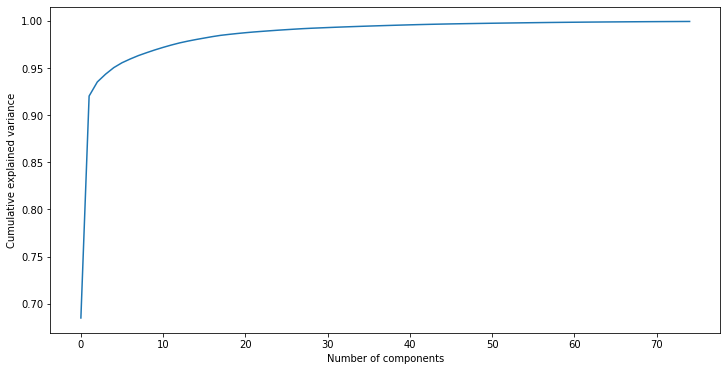

In [ ]:
import pandas as pd
groundt = x3
hisimg = x2
def extract_pixels(hisimg, groundt):
  q = hisimg.reshape(-1, hisimg.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = groundt.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+hisimg.shape[2])]+['class']
  # df.columns= [f'band{i}' for i in range(1, 1+hisimg.shape[2])]
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(hisimg, groundt)

from sklearn.decomposition import PCA

pca = PCA(n_components = 75)

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


In [ ]:
df.shape

(21025, 201)

PCA

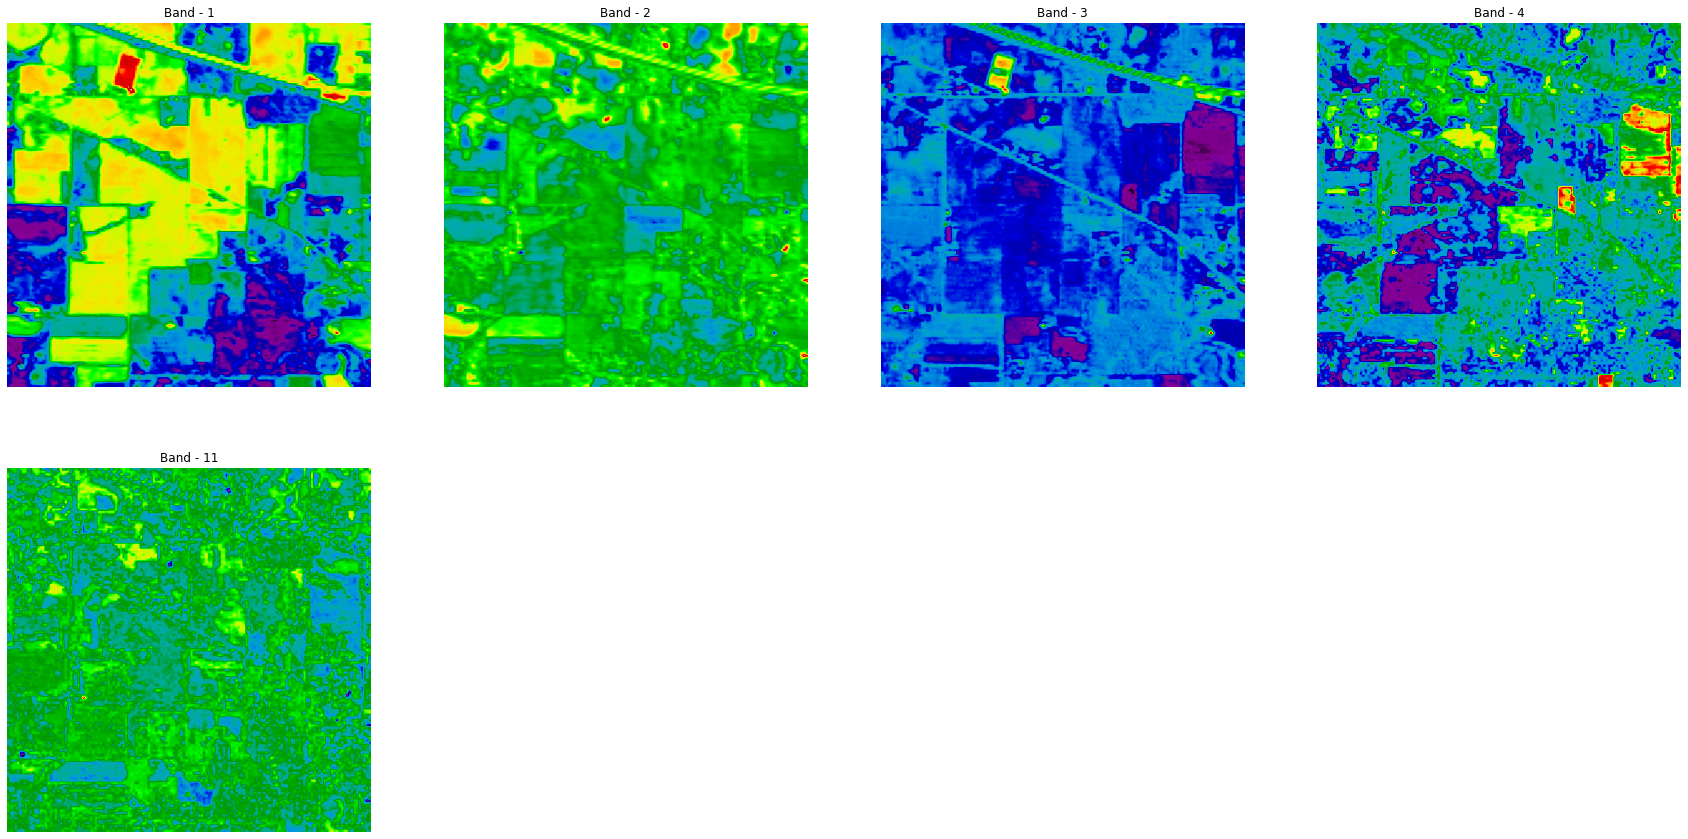

In [ ]:
pca = PCA(n_components = 11)
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = groundt.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,12)]+['class']

fig = plt.figure(figsize = (30, 15))

for i in range(1, 1+5):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')
    
plt.imshow(q.loc[:, f'PC-{11}'].values.reshape(145, 145), cmap='nipy_spectral')
plt.axis('off')
plt.title(f'Band - {11}')


q.to_csv('indianpines_11bands.csv', index=False)

elevenbandimg = q

elevenbandimg.drop('class', inplace=True, axis=1)
final11 = elevenbandimg.loc[:,:].values.reshape(145,145,11)

In [ ]:
dt.shape

(21025, 11)

creating patches

In [ ]:
from patchify import patchify, unpatchify
import cv2
patches = patchify(final11, (32, 32, 11), step = 2)
patches.shape
resized_patches = np.zeros((57, 57, 1, 16, 16, 11))
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        for k in range(patches.shape[2]):
            image = patches[i][j][k] 
            image.shape
            resized = cv2.resize(image, (16, 16))
            resized_patches[i][j][k] = resized 

In [ ]:
resized_patches.shape

(57, 57, 1, 16, 16, 11)

In [ ]:
patches.shape

(57, 57, 1, 32, 32, 11)

forming hr and lr data 

In [ ]:
hr_data = np.zeros((3249, 32, 32, 11))
lr_data = np.zeros((3249, 16, 16, 11))
count = 0
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      hr_data[count] = patches[i][j][k]
      lr_data[count] = resized_patches[i][j][k]
      count += 1

In [ ]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

def train_hr_transform():
    return Compose([
        ToTensor()
    ])

def train_lr_transform():
    return Compose([
        #ToPILImage(),
        ToTensor()
    ])

def display_transform():
    return Compose([
        
        ToTensor()
    ])


In [ ]:
class TrainDatasetFromFolder(Dataset):
    # def __init__(self, dataset_dir, lr_dir):
    def __init__(self, hr_data, lr_data):
        super(TrainDatasetFromFolder, self).__init__()
        # self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        # self.lr_images_filenames = [join(lr_dir, y) for y in listdir(lr_dir) if is_image_file(y)]
        self.hr_data = hr_data
        self.lr_data = lr_data
        self.hr_transform = train_hr_transform()
        self.lr_transform = train_lr_transform()

    def __getitem__(self, index):
        # hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        # lr_image = self.lr_transform(Image.open(self.lr_images_filenames[index]))
        hr_image = self.hr_transform(self.hr_data[index]).to(dtype=torch.float32)
        lr_image = self.lr_transform(self.lr_data[index]).to(dtype=torch.float32)
        # hr_image = self.hr_data[index]
        # lr_image = self.lr_data[index]
        # hr_image = torch.unsqueeze(hr_image, 1)
        # lr_image = torch.unsqueeze(lr_image, 1)
        return lr_image, hr_image

    def __len__(self):
        return len(self.hr_data)

forming dataset

In [ ]:
train_set = TrainDatasetFromFolder(hr_data, lr_data)
lr, hr = train_set.__getitem__(0)
lr.shape

torch.Size([11, 16, 16])

In [ ]:
%cd /content/gdrive/MyDrive/band attentioon github repo/GAN-HSI-SR-main

/content/gdrive/MyDrive/band attentioon github repo/GAN-HSI-SR-main


TRAINING

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from net import Generator, Discriminator,Spe_loss,TVLoss,ESR_Discriminator
from torch.utils.data import DataLoader
import torch.optim as optim
import copy
from G import *
from data import LoadData
from utils import SAM, PSNR_GPU
from pathlib import Path

Generator layer shapes - ROUGH

In [ ]:
KERNEL_SIZE = (5,3,3)
PAD_SIZE = (2,1,1)

class Attention(nn.Module):

    def __init__(self,bs, c, l=11, h=16, w=16):
        super(Attention,self).__init__()
        self.shape = [bs,c,l,h,w]

        self.conv_1 = nn.Sequential(
            nn.Conv3d(32, 32, KERNEL_SIZE, 1, (2,1,1)),
            nn.LeakyReLU(),

            nn.Conv3d(32, 32, KERNEL_SIZE,1,(2,1,1)),
            nn.LeakyReLU(),
        )
        self.avg_poll =  nn.AdaptiveAvgPool3d(
            (11,1,1)
        )


        self.conv_2 = nn.Sequential(
            nn.Linear(11,8,bias=False),
            nn.LeakyReLU(),

            nn.Linear(8,11,bias=False),
            nn.Sigmoid()
        )


    def forward(self,x):

        x1 = self.conv_1(x) 
        print('attention conv 1', x1.shape)
        x2 = self.avg_poll(x1) 
        print('attention avg pool', x2.shape)
        x2_1 = torch.squeeze(x2) 
        print('attention squeeze', x2_1.shape)
        x3 = self.conv_2(x2_1) 
        print('attention conv 2', x3.shape)
        x3_1 = x3.reshape(self.shape[0], self.shape[1], self.shape[2], 1, 1) 
        print('attention reshape', x3_1.shape)
        x4 = x1 * x3_1
        print('attention multiplcation', x4.shape)
        y = x + x4
        print('attention output', y.shape)
        return y



c = 1
l = 11
h = 16
w = 16
bs = 2
shape = [bs,c,l,h,w]
conv_1 = nn.Sequential(
            nn.Conv3d(1, 32, KERNEL_SIZE, 1, (2,1,1)),
            nn.LeakyReLU()
        )
attn_1 = Attention(bs, 32, l, h, w)
attn_2 = Attention(bs, 32, l, h, w)
attn_3 = Attention(bs, 32, l, h, w)

conv_2 = nn.Sequential(
            nn.Conv3d(32, 32, KERNEL_SIZE, 1, (2,1,1)),
            nn.LeakyReLU()
        )
conv_3 = nn.Conv3d(32, 1, KERNEL_SIZE, 1, (2,1,1))

conv_4 = nn.Sequential(
            nn.Conv3d(1, 1, KERNEL_SIZE, 1, (2,1,1)),
            nn.LeakyReLU()
        )
        
conv_5 = nn.Conv3d(1, 1, KERNEL_SIZE, 1, (2,1,1))

x = torch.zeros(size=(2, 1, 11, 16, 16))
x1 = conv_1(x)
print('gen layer 1', x1.shape)
x2 = attn_1(x1)
print('ATTENTION 1')
x2 = attn_2(x2)
print('ATTENTION 2')
x2 = attn_3(x2)
print('ATTENTION 3')
x2_1 = conv_2(x2)
print('gen layer 4', x2_1.shape)
x3 = x2_1 + x1
print('gen skip connection', x3.shape)

x4 = conv_3(x3)
print('up sample conv 1', x4.shape)
x4 = torch.squeeze(x4)
print('up sample squeeze 1', x4.shape)
x4 = F.interpolate(x4,scale_factor=1,mode='bicubic')
print('up sample interpolate 1', x4.shape)
x4 = x4.reshape(x4.shape[0],1,x4.shape[1],x4.shape[2],x4.shape[3])
print('up sample reshape', x4.shape)
x4 = conv_4(x4)
print('up sample conv 2', x4.shape)
x4 = torch.squeeze(x4)
print('up sample squeeze 2', x4.shape)
x4 = F.interpolate(x4,scale_factor=2,mode='bicubic')
print('up sample interpolate 2', x4.shape)
x4 = x4.reshape(x4.shape[0],1,x4.shape[1],x4.shape[2],x4.shape[3])
print('up sample reshape 2', x4.shape)
x4 = conv_4(x4)
print('up sample conv 3', x4.shape)

x4 = conv_4(x4)
print('gen layer 5', x4.shape)
x4 = conv_5(x4)
print('gen output', x4.shape)


gen layer 1 torch.Size([2, 32, 11, 16, 16])
attention conv 1 torch.Size([2, 32, 11, 16, 16])
attention avg pool torch.Size([2, 32, 11, 1, 1])
attention squeeze torch.Size([2, 32, 11])
attention conv 2 torch.Size([2, 32, 11])
attention reshape torch.Size([2, 32, 11, 1, 1])
attention multiplcation torch.Size([2, 32, 11, 16, 16])
attention output torch.Size([2, 32, 11, 16, 16])
ATTENTION 1
attention conv 1 torch.Size([2, 32, 11, 16, 16])
attention avg pool torch.Size([2, 32, 11, 1, 1])
attention squeeze torch.Size([2, 32, 11])
attention conv 2 torch.Size([2, 32, 11])
attention reshape torch.Size([2, 32, 11, 1, 1])
attention multiplcation torch.Size([2, 32, 11, 16, 16])
attention output torch.Size([2, 32, 11, 16, 16])
ATTENTION 2
attention conv 1 torch.Size([2, 32, 11, 16, 16])
attention avg pool torch.Size([2, 32, 11, 1, 1])
attention squeeze torch.Size([2, 32, 11])
attention conv 2 torch.Size([2, 32, 11])
attention reshape torch.Size([2, 32, 11, 1, 1])
attention multiplcation torch.Size(

Discriminator layer shapes - ROUGH

In [ ]:
conv1 = nn.Sequential(nn.Conv3d(1,32,KERNEL_SIZE,1,(2,1,1)),
            nn.LeakyReLU())

constpad1 = nn.ConstantPad3d((1,0,1,0,1,2),1)
conv2 = nn.Sequential(nn.Conv3d(32,32,KERNEL_SIZE,2),
            nn.LeakyReLU())
conv3 = nn.Sequential(nn.Conv3d(32,64,KERNEL_SIZE,1,(2,1,1)),
            nn.LeakyReLU())
            
constpad2 = nn.ConstantPad3d((1,0,1,0,1,2),1 )
conv4 = nn.Sequential(nn.Conv3d(64,64,KERNEL_SIZE,2),
            nn.LeakyReLU())
            
conv5 = nn.Sequential(nn.Conv3d(64,128,KERNEL_SIZE,1,(2,1,1)),
            nn.LeakyReLU())
            
conv6 = nn.Sequential(nn.Conv3d(128,128,KERNEL_SIZE,1,(2,1,1)),
            nn.LeakyReLU())
avgpool = nn.AdaptiveAvgPool3d((1,1,1))

linear1 = nn.Sequential(
            
            nn.Linear(128,256),
            nn.LeakyReLU())
linear2 = nn.Linear(256,1)
x = torch.zeros(size=(2, 1, 11, 32, 32))
y = conv1(x)
print('conv1', y.shape)
y = constpad1(y)
print('constpad1', y.shape)
y = conv2(y)
print('conv2', y.shape)
y = conv3(y)
print('conv3', y.shape)
y = constpad2(y)
print('constpad2', y.shape)
y = conv4(y)
print('conv4', y.shape)
y = conv5(y)
print('conv5', y.shape)
y = conv6(y)
print('conv6', y.shape)
y = avgpool(y)
print('avgpool', y.shape)
y = torch.squeeze(y)
y = linear1(y)
print('linear1', y.shape)
y = linear2(y)
print('output', y.shape)

conv1 torch.Size([2, 32, 11, 32, 32])
constpad1 torch.Size([2, 32, 14, 33, 33])
conv2 torch.Size([2, 32, 5, 16, 16])
conv3 torch.Size([2, 64, 5, 16, 16])
constpad2 torch.Size([2, 64, 8, 17, 17])
conv4 torch.Size([2, 64, 2, 8, 8])
conv5 torch.Size([2, 128, 2, 8, 8])
conv6 torch.Size([2, 128, 2, 8, 8])
avgpool torch.Size([2, 128, 1, 1, 1])
linear1 torch.Size([2, 256])
output torch.Size([2, 1])


# **Training**

In [ ]:
EPOCHS = 20
BATCH_SIZE = 19
LR = 1e-3
WARM_UP_EPOCH = 100

# if __name__ == "__main__":

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

torch.manual_seed(0)
torch.cuda.manual_seed(0)

g_model = Generator(BATCH_SIZE).to(device)
d_model = Discriminator(BATCH_SIZE).to(device)

    
    # g_criterion = Loss()
criterion_spe = Spe_loss().to(device)
criterion_GAN = nn.BCEWithLogitsLoss().to(device)
    # criterion_content = nn.L1Loss().to(device)
criterion_pixel = nn.L1Loss().to(device)



g_optimizer = optim.Adam(
        g_model.parameters(),
        lr = LR,
        betas=(0.9, 0.999))
d_optimizer = optim.Adam(
        d_model.parameters(),
        lr = LR,
        betas=(0.9, 0.999)
    )

best_sorce = {
        'psnr'  : 0.0,
        'sam'   : 180.0,
        'epoch' : 0,
    }
for epoch in range(EPOCHS):

      train_data = DataLoader(
            train_set,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers= 2, 
            pin_memory= True,
            drop_last= True,
        )

      count = 0
      counters = 0
      fake_image_array = np.zeros(shape=(3249, 32, 32, 11))
      real_image_array = np.zeros(shape=(3249, 32, 32, 11))

      for lr, hr in train_data:
            # bs 31 36 36  / bs 31 144 144
          lr = lr.reshape((lr.shape[0],1,lr.shape[1],lr.shape[2],lr.shape[3]))
          lr = lr.to(device)
          hr = hr.reshape((hr.shape[0],1,hr.shape[1],hr.shape[2],hr.shape[3]))
          hr = hr.to(device)
            #shape
          print(lr.shape, hr.shape)
          real_labels = torch.ones(BATCH_SIZE,1).to(device)
          fake_labels = torch.zeros(BATCH_SIZE,1).to(device)

            
            

          g_optimizer.zero_grad()
            
          fake_hr = g_model(lr)
            # l1 loss
          loss_pixel = criterion_pixel(fake_hr,hr)


            
          # if epoch < WARM_UP_EPOCH:
          #     loss_pixel.backward()
          #     g_optimizer.step()
          #     print('warm up epoch {} pixel loss {:.4f}'.format(epoch,loss_pixel.item()))
          #     continue

          pre_real = d_model(hr)
          pre_fake = d_model(fake_hr)
           
            
          loss_GAN = criterion_GAN(pre_fake-pre_real.mean(0,keepdim=True),real_labels)
            
          loss_spe = criterion_spe(fake_hr,hr)

          loss_G = loss_pixel + 1e-3*loss_GAN + 1e-2*loss_spe

          loss_G.backward()
          g_optimizer.step()
            

            
            
          d_optimizer.zero_grad()

          fake_hr = g_model(lr)

          pre_real = d_model(hr)
          pre_fake = d_model(fake_hr)

          loss_real = criterion_GAN(pre_real-pre_fake.mean(0,keepdim=True),real_labels)
          loss_fake = criterion_GAN(pre_fake - pre_real.mean(0,keepdim=True),fake_labels)
          loss_D = (loss_fake + loss_real) / 2
            
          loss_D.backward()
          d_optimizer.step()
          if epoch == EPOCHS - 1:   
            for i in range(19):
              fake_img = fake_hr[i][0].permute((1, 2, 0)).cpu().detach().numpy() 
              real_img = hr[i][0].permute((1, 2, 0)).cpu().detach().numpy()
              fake_image_array[counters + i] = fake_img
              real_image_array[counters + i] = real_img
            # fake_img1 = fake_hr[0][0].permute((1, 2, 0)).cpu().detach().numpy()
            # fake_img2 = fake_hr[1][0].permute((1, 2, 0)).cpu().detach().numpy()
            # real_img1 = hr[0][0].permute((1, 2, 0)).cpu().detach().numpy()
            # real_img2 = hr[1][0].permute((1, 2, 0)).cpu().detach().numpy()
            # # print(f'{counters}')
            # # view = imshow(real_img1, (0, 0, 1))
            # # view = imshow(fake_img1, (0, 0, 1))
            # # print(f'{counters + 1}')
            # # view = imshow(real_img2, (0, 0, 1))
            # # view = imshow(fake_img2, (0, 0, 1))

            # fake_image_array[counters] = fake_img1
            # fake_image_array[counters + 1] = fake_img2
            # real_image_array[counters] = real_img1
            # real_image_array[counters + 1] = real_img2
            

#           print("EPOCH {} step {} G-L1 {:.4f} G-GAN {:.4f} G-SPE {:.4f} \
# D-TOTAL {:.4f} D-REAL {:.4f} D-FAKE {:.4f}".format(
#                 epoch,
#                 count,
#                 # loss_pixel.item(),
#                 # loss_GAN.item(),
#                 loss_spe.item(),
#                 # loss_D.item(),
#                 # loss_real.item(),
#                 # loss_fake.item()
#             ))

          print("EPOCH {} step {}  G-SPE {:.4f}".format(
                epoch,
                count,
                # loss_pixel.item(),
                # loss_GAN.item(),
                loss_spe.item(),
                # loss_D.item(),
                # loss_real.item(),
                # loss_fake.item()
            ))

          count += 1
          counters += 19

            


      g_model.eval()
      d_model.eval()
      val_count = 0
      val_psnr = 0
      val_sam = 0
      

    

Streaming output truncated to the last 5000 lines.
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 65  G-SPE 0.4151
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 66  G-SPE 0.4090
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 67  G-SPE 0.3274
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 68  G-SPE 0.4269
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 69  G-SPE 0.3910
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 70  G-SPE 0.3331
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 71  G-SPE 0.4350
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 72  G-SPE 0.3806
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 73  G-SPE 0.3415
torch.Size([19, 1, 11, 16, 16]) torch.Size([19, 1, 11, 32, 32])
EPOCH 5 step 74  G-SPE 0.4376
torch.Siz

In [ ]:
# torch.save(g_model, 'HSIGAN_rough.pt')

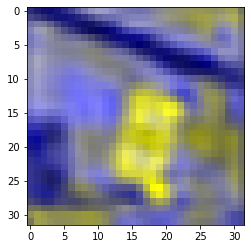

In [ ]:
view = imshow(fake_image_array[15], (0, 0, 1))

Generated and original patches after SR

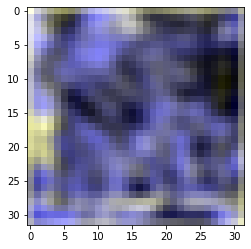

In [ ]:
viewing_fake_hr = fake_hr[1][0].permute((1, 2, 0)).cpu().detach().numpy()
view = imshow(viewing_fake_hr, (0, 0, 1))

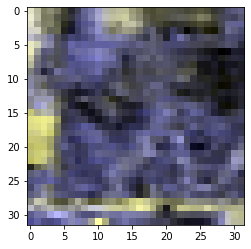

In [ ]:
viewing_hr = hr[1][0].permute((1, 2, 0)).cpu().detach().numpy()
view = imshow(viewing_hr, (0, 0, 1))

In [ ]:
unpatchify_array = np.empty((57, 57, 1, 32, 32, 11))
count = 0
for i in range(unpatchify_array.shape[0]):
  for j in range(unpatchify_array.shape[1]):
    for k in range(unpatchify_array.shape[2]):
      unpatchify_array[i][j][k] = fake_image_array[count]
      count += 1


Reconstruction of SR 

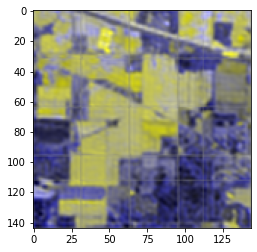

In [ ]:
reconstructed = unpatchify(unpatchify_array, (144, 144, 11))
view = imshow(reconstructed, (0,0, 1))

 original low resolution patches

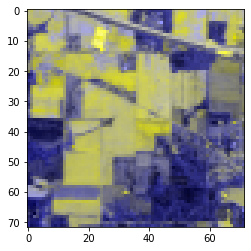

In [ ]:
reconstructed_low = unpatchify(resized_patches, (72,72,11))
viewx = imshow(reconstructed_low, (0,0,1))

In [ ]:
reconstructed.shape


(144, 144, 11)

In [ ]:
band1 = reconstructed[:,:,0]
band1.shape

(144, 144)

Illustration of some bands

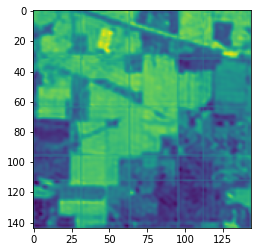

In [ ]:
plt.imshow(band1)
plt.savefig('bandatten_band1.png')

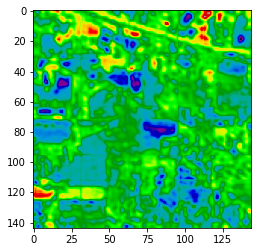

In [ ]:
band2 = reconstructed[:,:,1]
band2.shape
plt.imshow(band2,cmap='nipy_spectral')

Performing inverse PCA to obtain image in 200 bands for SR and low resolution images

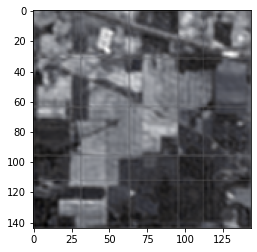

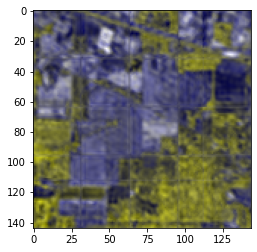

In [ ]:
pca_inverse = pca.inverse_transform(reconstructed)
view = imshow(pca_inverse, (4, 6, 10))
plt.savefig('original(4, 6, 10).png')
view = imshow(pca_inverse, (0, 0, 1))
plt.savefig('original(0, 0, 1).png')

In [ ]:
pca_inverse.shape

(144, 144, 200)

In [ ]:
print(type(pca_inverse))

<class 'numpy.ndarray'>


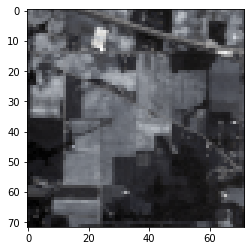

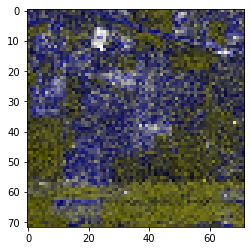

In [ ]:
pca_inverse_low = pca.inverse_transform(reconstructed_low)
view = imshow(pca_inverse_low, (4, 6, 10))
# plt.savefig('original(4, 6, 10).png')
view = imshow(pca_inverse_low, (0, 0, 1))
# plt.savefig('original(0, 0, 1).png')

In [ ]:
pca_inverse_low.shape

(72, 72, 200)



```
# This is formatted as code
```

# **Classification start**


Factor analysis

In [ ]:
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa

In [ ]:
dataset = 'IP'
test_ratio = 0.9
windowSize = 64

In [ ]:
data2 = loadmat(r"/content/gdrive/MyDrive/jndsljn/Indian_pines_corrected.mat")
f2 = data2["indian_pines_corrected"]
data3 = loadmat(r"/content/gdrive/MyDrive/jndsljn/Indian_pines_gt.mat")
f3 = data3["indian_pines_gt"]

In [ ]:
f2.shape

(145, 145, 200)

loading data as SR image and ground truth

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = pca_inverse
        labels = sio.loadmat(os.path.join(data_path, '/content/gdrive/MyDrive/jndsljn/Indian_pines_gt.mat'))['indian_pines_gt']
    # elif name == 'SA':
    #     data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
    #     labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    # elif name == 'PU':
    #     data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    #     labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

Zero padding with 2 layers

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

creation of patches

In [ ]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((144, 144, 200), (145, 145))

In [ ]:
print(type(y))

<class 'numpy.ndarray'>


In [ ]:
y_del1 = np.delete(y,144,0)
y_del2 = np.delete(y_del1,144,1)

In [ ]:
y_del2.shape

(144, 144)

In [ ]:
K = X.shape[2]

In [ ]:
print(K)

200


In [ ]:
K = 3 if dataset == 'IP' else 3
X,fa = applyFA(X,numComponents=K)

X.shape

(144, 144, 3)

In [ ]:
X, y = createImageCubes(X, y_del2, windowSize=windowSize)

X.shape, y.shape

((10249, 64, 64, 3), (10249,))

perform the train test split

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((1024, 64, 64, 3), (9225, 64, 64, 3), (1024,), (9225,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(1024, 64, 64, 3, 1)

converts target training vector into a form against the 16 categories

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(1024, 16)

In [ ]:
S1 = windowSize
L1 = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

wavelet transform functions along the x and y axes

In [ ]:
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = Kb.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = Kb.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = Kb.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = Kb.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

main wavelet function, with 4 level decomposition

In [ ]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = Kb.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = Kb.stack(wavelet_data, axis=1)

    # level 2 decomposition - taking only the trend from level 1
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = Kb.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition - taking only the trend from level 2
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = Kb.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition - taking only the trend from level 3
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = Kb.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    # reshaping the wavelet transforms after decomposition
    decom_level_1 = Kb.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = Kb.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = Kb.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = Kb.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [ ]:
img_batch = Kb.zeros(shape=(8, 64, 64, 3), dtype='float32')
Wavelet(img_batch)

[<tf.Tensor: shape=(8, 32, 32, 12), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          .

# **ROUGH**

In [ ]:
def get_wavelet_cnn_model_rough():
 
    input_shape =  64, 64, 3
 
    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    print('LEVEL 1 DECOMPOSITION \n')
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)
    print(f'relu_1 {relu_1.shape}')
 
    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    print(f'relu_1_2 {relu_1_2.shape}')
 
    # level two decomposition starts
    print('LEVEL 2 DECOMPOSITION \n')
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)
    print(f'relu_a {relu_a.shape}')
 
    # concate level one and level two concatenation
    concate_level_2 = concatenate([relu_1_2, relu_a])
    print(f'concatenate 1 and 2 {concate_level_2.shape}')
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)
    print(f'relu_2 {relu_2.shape}')
 
    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)
    print(f'relu_2_2 {relu_2_2.shape}')
 
    # level three decomposition starts 
    print('LEVEL 3 DECOMPOSITION \n')

    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)
    print(f'relu_b {relu_b.shape}')
 
    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)
    print(f'relu_b_2.shape')
 
    # concate level two and level three concatenation 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    print(f'concatenate 2 and 3 {concate_level_3.shape}')
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)
    print(f'relu_3 {relu_3.shape}')
 
    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)
    print(f'relu_3_2 {relu_3_2.shape}')
 
    # level four decomposition start
    print('LEVEL 4 DECOMPOSITION \n')
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)
    print(f'relu_c {relu_c.shape}')
 
    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)
    print(f'relu_c_2 {relu_c_2.shape}')
 
    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)
    print(f'relu_c_3 {relu_c_3.shape}')
 
    # concate level level three and level four concatenation
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    print(f'concatenate 3 and 4 {concate_level_4.shape}')
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)
    print(f'relu_4 {relu_4.shape}')
 
    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)
    print(f'relu_4_2 {relu_4_2.shape}')
 
    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)
    print(f'relu_5_1 {relu_5_1.shape}')
 
    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    print(f'Average pooling last {pool_5_1.shape}')
    #flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 
 
    #fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    #norm_5 = BatchNormalization(name='norm_5')(fc_5)
    #relu_5 = Activation('relu', name='relu_5')(norm_5)
    #drop_5 = Dropout(0.5, name='drop_5')(relu_5)
 
    #fc_6 = Dense(2048, name='fc_6')(drop_5)
    #norm_6 = BatchNormalization(name='norm_6')(fc_6)
    #relu_6 = Activation('relu', name='relu_6')(norm_6)
    #drop_6 = Dropout(0.5, name='drop_6')(relu_6)
    flatten_layer = Flatten()(pool_5_1)
    print(f'Flatten {flatten_layer.shape}')
 
    dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    print(f'dense_1 {dense_layer1.shape}')
    dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    print(f'dense_2 {dense_layer2.shape}')
    output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)
    print(f'output {output_layer.shape}')
 
    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')
 
    return model

model = get_wavelet_cnn_model_rough()
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(x=Xtrain, y=ytrain, batch_size = 30, epochs=1)


LEVEL 1 DECOMPOSITION 

relu_1 (None, 32, 32, 64)
relu_1_2 (None, 16, 16, 64)
LEVEL 2 DECOMPOSITION 

relu_a (None, 16, 16, 64)
concatenate 1 and 2 (None, 16, 16, 128)
relu_2 (None, 16, 16, 128)
relu_2_2 (None, 8, 8, 128)
LEVEL 3 DECOMPOSITION 

relu_b (None, 8, 8, 64)
relu_b_2.shape
concatenate 2 and 3 (None, 8, 8, 256)
relu_3 (None, 8, 8, 256)
relu_3_2 (None, 4, 4, 256)
LEVEL 4 DECOMPOSITION 

relu_c (None, 4, 4, 64)
relu_c_2 (None, 4, 4, 256)
relu_c_3 (None, 4, 4, 256)
concatenate 3 and 4 (None, 4, 4, 512)
relu_4 (None, 4, 4, 256)
relu_4_2 (None, 2, 2, 256)
relu_5_1 (None, 2, 2, 128)
Average pooling last (None, 2, 2, 128)
Flatten (None, 512)
dense_1 (None, 2048)
dense_2 (None, 1024)
output (None, 16)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 64, 64, 3)]  0           []       

Classification model

In [ ]:
def get_wavelet_cnn_model():
 
    input_shape =  64, 64, 3
 
    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)
 
    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)
 
    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)
 
    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)
 
    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)
 
    # level three decomposition starts 
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)
 
    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)
 
    # concate level two and level three decomposition 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)
 
    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)
 
    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)
 
    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)
 
    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)
 
    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)
 
    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)
 
    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)
 
    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    #flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 
 
    #fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    #norm_5 = BatchNormalization(name='norm_5')(fc_5)
    #relu_5 = Activation('relu', name='relu_5')(norm_5)
    #drop_5 = Dropout(0.5, name='drop_5')(relu_5)
 
    #fc_6 = Dense(2048, name='fc_6')(drop_5)
    #norm_6 = BatchNormalization(name='norm_6')(fc_6)
    #relu_6 = Activation('relu', name='relu_6')(norm_6)
    #drop_6 = Dropout(0.5, name='drop_6')(relu_6)
    flatten_layer = Flatten()(pool_5_1)
 
    dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)
 
    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')
 
    return model

In [ ]:
model = get_wavelet_cnn_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 wavelet (Lambda)               [(None, 32, 32, 12)  0           ['the_input[0][0]']              
                                , (None, 16, 16, 12                                               
                                ),                                                                
                                 (None, 8, 8, 12),                                                
                                 (None, 4, 4, 12)]                                                
                                                                                            

In [ ]:
#adam = Adam(lr=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size = 30, epochs=100, callbacks=callbacks_list)

Epoch 1/100
34/35 [============================>.] - ETA: 0s - loss: 1.7686 - accuracy: 0.4500
Epoch 1: saving model to best-model.hdf5
35/35 [==============================] - 9s 162ms/step - loss: 1.7635 - accuracy: 0.4521
Epoch 2/100
34/35 [============================>.] - ETA: 0s - loss: 0.5205 - accuracy: 0.8637
Epoch 2: saving model to best-model.hdf5
35/35 [==============================] - 2s 71ms/step - loss: 0.5226 - accuracy: 0.8633
Epoch 3/100
34/35 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.9441
Epoch 3: saving model to best-model.hdf5
35/35 [==============================] - 3s 72ms/step - loss: 0.2272 - accuracy: 0.9443
Epoch 4/100
34/35 [============================>.] - ETA: 0s - loss: 0.1362 - accuracy: 0.9657
Epoch 4: saving model to best-model.hdf5
35/35 [==============================] - 2s 71ms/step - loss: 0.1361 - accuracy: 0.9658
Epoch 5/100
34/35 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9784
Epoch 5:

Loss vs epochs convergence graph

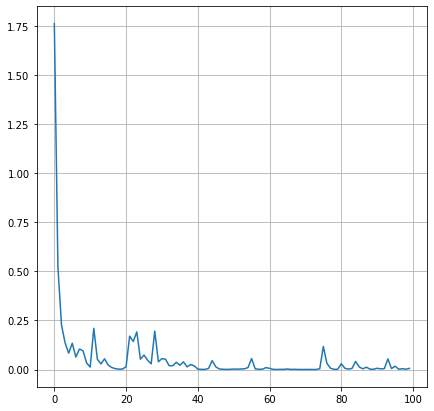

In [ ]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])

In [ ]:
%cd /content/gdrive/MyDrive/band attentioon github repo/GAN-HSI-SR-main

/content/gdrive/MyDrive/band attentioon github repo/GAN-HSI-SR-main


In [ ]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(9225, 64, 64, 3, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(9225, 16)

classification report

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
 
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        41
           1       1.00      0.95      0.97      1285
           2       0.98      1.00      0.99       747
           3       0.98      0.99      0.98       213
           4       1.00      0.98      0.99       435
           5       0.99      0.99      0.99       657
           6       0.96      1.00      0.98        25
           7       1.00      1.00      1.00       430
           8       0.93      0.78      0.85        18
           9       0.98      0.99      0.99       875
          10       0.97      1.00      0.99      2210
          11       0.99      0.96      0.97       534
          12       0.97      1.00      0.99       185
          13       1.00      1.00      1.00      1139
          14       0.97      1.00      0.99       347
          15       0.91      0.93      0.92        84

    accuracy                           0.99      9225
   macro avg       0.97   

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)

289/289 [==============================] - 11s 29ms/step - loss: 0.1392 - accuracy: 0.9853


In [ ]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
X.shape

(144, 144, 200)

In [ ]:
y.shape

(145, 145)

In [ ]:
y_del1 = np.delete(y,144,0)
y_del2 = np.delete(y_del1,144,1)
y = y_del2

In [ ]:
y.shape

(144, 144)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [ ]:
K = 3
X,fa = applyFA(X, numComponents=K)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

In [ ]:
import spectral

Original ground truth

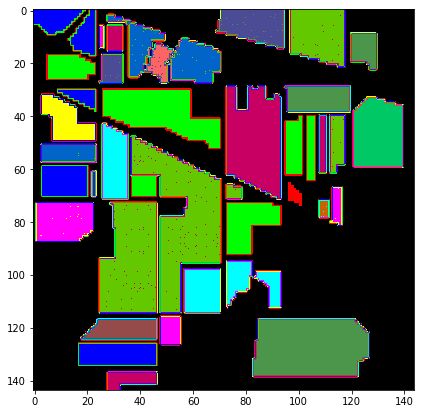

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

Ground truth of predicted image

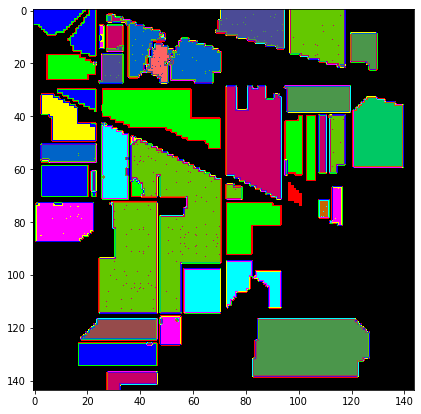

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

# **Classification for Low Resolution Image**

In [ ]:
dataset = 'IP'
test_ratio = 0.9
windowSize = 64

In [ ]:
def loadData2(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = pca_inverse_low
        labels = sio.loadmat(os.path.join(data_path, '/content/gdrive/MyDrive/jndsljn/Indian_pines_gt.mat'))['indian_pines_gt']
    # elif name == 'SA':
    #     data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
    #     labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    # elif name == 'PU':
    #     data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    #     labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData2(dataset)

X.shape, y.shape

((72, 72, 200), (145, 145))

In [ ]:
y_res = cv2.resize(y, (72, 72))

In [ ]:
y_res.shape

(72, 72)

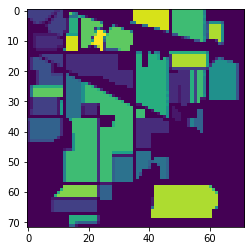

In [ ]:
plt.imshow(y_res)

In [ ]:
K = X.shape[2]

In [ ]:
K = 3 if dataset == 'IP' else 3
X,fa = applyFA(X,numComponents=K)

X.shape

(72, 72, 3)

In [ ]:
X, y = createImageCubes(X, y_res, windowSize=windowSize)

X.shape, y.shape

((2774, 64, 64, 3), (2774,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((277, 64, 64, 3), (2497, 64, 64, 3), (277,), (2497,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(277, 64, 64, 3, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(277, 16)

In [ ]:
S1 = windowSize
L1 = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = Kb.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = Kb.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = Kb.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = Kb.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [ ]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = Kb.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = Kb.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = Kb.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = Kb.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = Kb.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = Kb.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = Kb.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = Kb.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = Kb.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
    
    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]), 
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [ ]:
img_batch = Kb.zeros(shape=(8, 64, 64, 3), dtype='float32')
Wavelet(img_batch)

[<tf.Tensor: shape=(8, 32, 32, 12), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          .

In [ ]:
def get_wavelet_cnn_model():
 
    input_shape =  64, 64, 3
 
    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)
 
    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)
 
    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)
 
    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)
 
    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)
 
    # level three decomposition starts 
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)
 
    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)
 
    # concate level two and level three decomposition 
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)
 
    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)
 
    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)
 
    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)
 
    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)
 
    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)
 
    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)
 
    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)
 
    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    #flat_5_1 = Flatten(name='flat_5_1')(pool_5_1) 
 
    #fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    #norm_5 = BatchNormalization(name='norm_5')(fc_5)
    #relu_5 = Activation('relu', name='relu_5')(norm_5)
    #drop_5 = Dropout(0.5, name='drop_5')(relu_5)
 
    #fc_6 = Dense(2048, name='fc_6')(drop_5)
    #norm_6 = BatchNormalization(name='norm_6')(fc_6)
    #relu_6 = Activation('relu', name='relu_6')(norm_6)
    #drop_6 = Dropout(0.5, name='drop_6')(relu_6)
    flatten_layer = Flatten()(pool_5_1)
 
    dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)
 
    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')
 
    return model

In [ ]:
model = get_wavelet_cnn_model()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 wavelet (Lambda)               [(None, 32, 32, 12)  0           ['the_input[0][0]']              
                                , (None, 16, 16, 12                                               
                                ),                                                                
                                 (None, 8, 8, 12),                                                
                                 (None, 4, 4, 12)]                                                
                                                                                            

In [ ]:
#adam = Adam(lr=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
filepath = "best-model2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size = 30, epochs=100, callbacks=callbacks_list)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 2.5469 - accuracy: 0.1588
Epoch 1: saving model to best-model2.hdf5
10/10 [==============================] - 7s 414ms/step - loss: 2.5469 - accuracy: 0.1588
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.9774 - accuracy: 0.3630
Epoch 2: saving model to best-model2.hdf5
10/10 [==============================] - 1s 141ms/step - loss: 1.9578 - accuracy: 0.3718
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 1.3472 - accuracy: 0.5926
Epoch 3: saving model to best-model2.hdf5
10/10 [==============================] - 1s 123ms/step - loss: 1.3371 - accuracy: 0.5921
Epoch 4/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.7612 - accuracy: 0.8111
Epoch 4: saving model to best-model2.hdf5
10/10 [==============================] - 1s 115ms/step - loss: 0.7500 - accuracy: 0.8159
Epoch 5/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4318 - accuracy: 0.8741
E

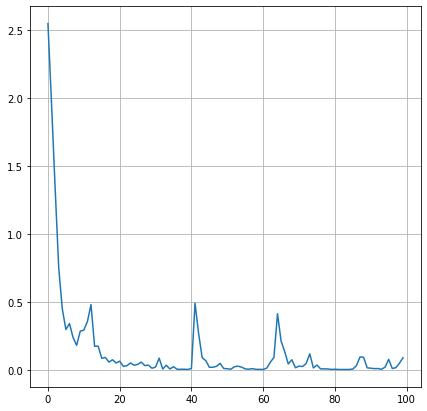

In [ ]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])

In [ ]:
# load best weights
model.load_weights("best-model2.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(2497, 64, 64, 3, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(2497, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
 
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.26      0.22      0.24       107
           1       0.81      0.45      0.58       396
           2       0.61      0.78      0.68       190
           3       0.42      0.31      0.36        78
           4       0.87      0.41      0.55       128
           5       0.60      0.79      0.68       165
           6       0.22      0.16      0.18        38
           7       0.55      0.76      0.64       144
           8       0.33      0.08      0.13        25
           9       0.41      0.77      0.53       225
          10       0.89      0.79      0.83       491
          11       0.70      0.58      0.63       114
          12       0.92      0.81      0.86        43
          13       0.90      0.93      0.92       258
          14       0.78      0.85      0.81        81
          15       0.52      0.86      0.65        14

    accuracy                           0.66      2497
   macro avg       0.61   

In [ ]:
y_pred_test.shape, np.argmax(ytest, axis=1).shape

((2497,), (2497,))

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)

79/79 [==============================] - 5s 38ms/step - loss: 2.2415 - accuracy: 0.6644


In [ ]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData2(dataset)

In [ ]:
y_res = cv2.resize(y, (72, 72))
y = y_res

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [ ]:
K = 3
X,fa = applyFA(X, numComponents=K)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

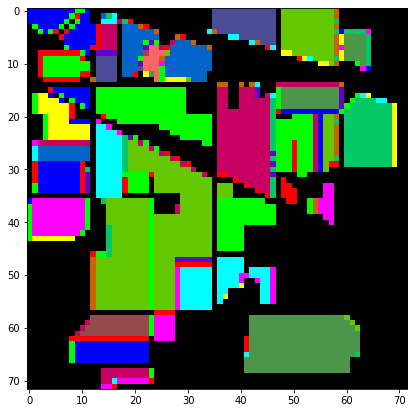

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

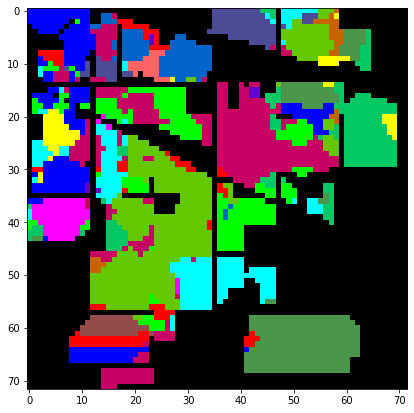

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

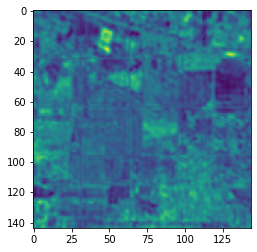

In [ ]:
plt.imshow(pca_inverse[:, :, 0])

band 0


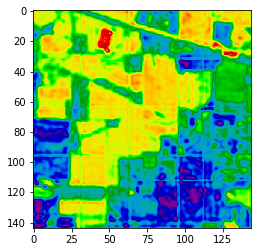

band 1


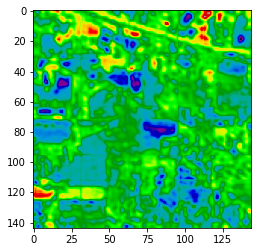

band 2


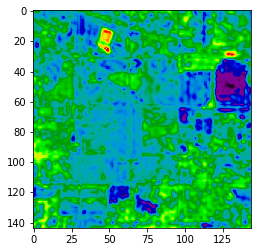

band 3


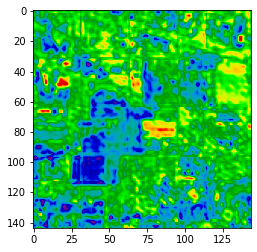

band 4


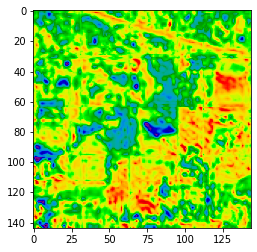

band 5


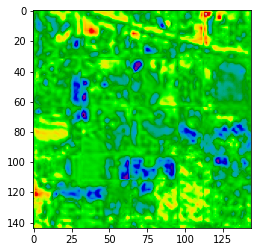

band 6


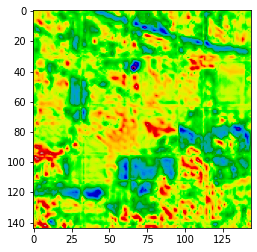

band 7


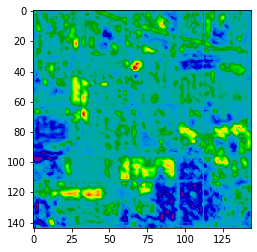

band 8


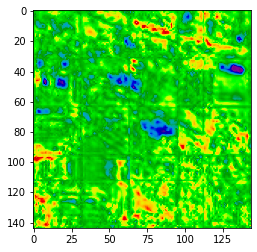

band 9


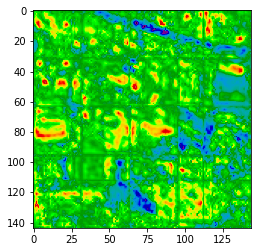

band 10


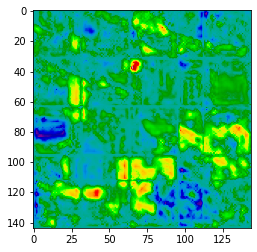

In [ ]:
for i in range(11):
  band = reconstructed[:,:,i]
  # band2.shape
  print(f'band {i}')
  plt.imshow(band,cmap='nipy_spectral')
  plt.savefig(f'band{i}.png')
  plt.show()

band 0


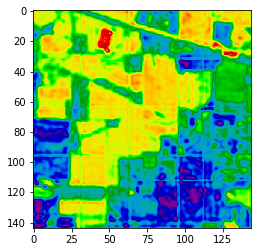

band 1


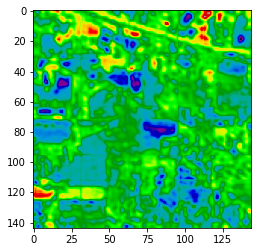

band 2


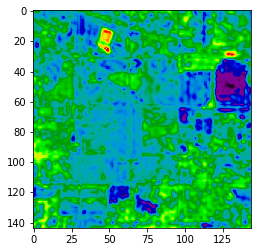

band 3


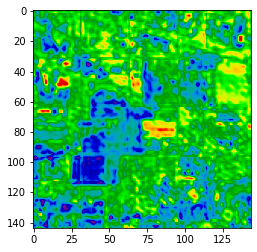

band 4


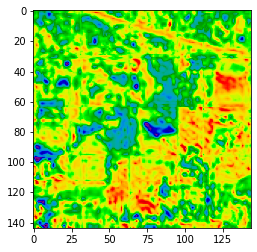

band 5


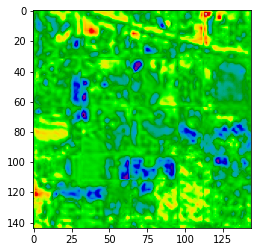

band 6


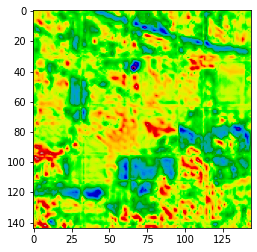

band 7


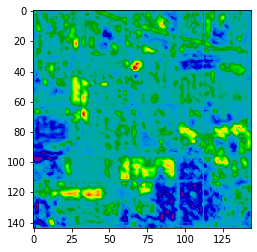

band 8


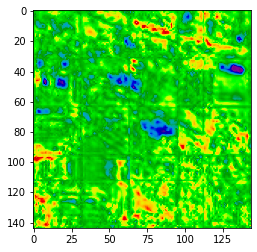

band 9


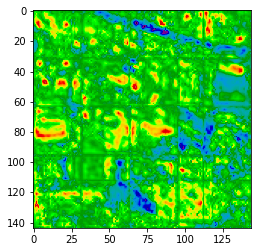

band 10


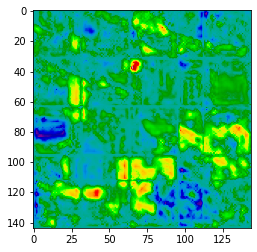

In [ ]:
for i in range(11):
  band2 = reconstructed[:,:,i]
  # band2.shape
  print(f'band {i}')
  plt.imshow(band2,cmap='nipy_spectral')
  plt.savefig(f'bandr{i}.png')
  plt.show()

# **END OF CODE**